In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn import datasets
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

import pandas as pd
import rdkit
from rdkit import Chem
from rdkit.Chem import Draw
import deepchem

from pytorch_model_summary import summary
import selfies as sf
from datasets import load_dataset

from tqdm.notebook import tqdm as tqdm

/home/marbesu/opt/mambaforge/envs/intro-dgm-env/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Skipped loading some Tensorflow models, missing a dependency. No module named 'tensorflow'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'torch_geometric'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. cannot import name 'DMPNN' from 'deepchem.models.torch_models' (/home/marbesu/opt/mambaforge/envs/intro-dgm-env/lib/python3.9/site-packages/deepchem/models/torch_models/__init__.py)
Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'pytorch_lightning'
Skipped loading some Jax models, missing a dependency. No module named 'jax'
/home/marbesu/opt/mambaforge/envs/intro-dgm-env/lib

In [93]:
train_dataset = load_dataset("jarod0411/PubChem10M_Canonicalized_SELFIES", split="train")

/home/marbesu/opt/mambaforge/envs/intro-dgm-env/lib/python3.9/site-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by mode='default'.
  table = cls._concat_blocks(blocks, axis=0)


In [3]:
alphabet = sf.get_alphabet_from_selfies(train_dataset["selfies"])
alphabet.add("[nop]")  # [nop] is a special padding symbol
alphabet = list(sorted(alphabet))  # ['[=O]', '[C]', '[F]', '[O]', '[nop]']

In [94]:
alphabet

['[#AsH1]',
 '[#B]',
 '[#Branch1]',
 '[#Branch2]',
 '[#Branch3]',
 '[#C-1]',
 '[#C]',
 '[#Ce]',
 '[#Co]',
 '[#Cr]',
 '[#Dy]',
 '[#Eu]',
 '[#Gd]',
 '[#Ge]',
 '[#Ho]',
 '[#Mo+1]',
 '[#Mo]',
 '[#N+1]',
 '[#N]',
 '[#Nd]',
 '[#O+1]',
 '[#Os]',
 '[#P+1]',
 '[#P]',
 '[#Pr]',
 '[#Re]',
 '[#Ring1]',
 '[#Ring2]',
 '[#S-1]',
 '[#SH1]',
 '[#S]',
 '[#Sb]',
 '[#Se]',
 '[#SiH1]',
 '[#Si]',
 '[#Ta+1]',
 '[#Tb]',
 '[#Te]',
 '[#U]',
 '[#W+1]',
 '[#W]',
 '[#Y]',
 '[=Ag]',
 '[=Al]',
 '[=AsH1]',
 '[=As]',
 '[=Au]',
 '[=B-1]',
 '[=B]',
 '[=Ba]',
 '[=Bi+1]',
 '[=Bi]',
 '[=Branch1]',
 '[=Branch2]',
 '[=Branch3]',
 '[=C+1]',
 '[=C-1]',
 '[=CH1-1]',
 '[=C]',
 '[=Cd]',
 '[=Ce]',
 '[=Co]',
 '[=Cr]',
 '[=Cu]',
 '[=Eu]',
 '[=Fe+1]',
 '[=FeH1]',
 '[=Fe]',
 '[=Ga]',
 '[=GeH1]',
 '[=Ge]',
 '[=Hf+2]',
 '[=Hf]',
 '[=Hg]',
 '[=In]',
 '[=Ir]',
 '[=Mn]',
 '[=Mo+2]',
 '[=Mo]',
 '[=N+1]',
 '[=N-1]',
 '[=NH1+1]',
 '[=NH2+1]',
 '[=N]',
 '[=Nb]',
 '[=Ni]',
 '[=O+1]',
 '[=OH1+1]',
 '[=O]',
 '[=Os+2]',
 '[=Os]',
 '[=P+1]',
 '[=P-

In [23]:
# pad_to_len = max(sf.len_selfies(s) for s in train_dataset["selfies"])  # 5
pad_to_len = 100
vocab_stoi = {symbol: idx for idx, symbol in enumerate(alphabet)}
vocab_itos = {idx: symbol for symbol, idx in vocab_stoi.items()}

In [24]:
def encoder(selfies, vocab_stoi=vocab_stoi, pad_to_len=pad_to_len):
    encoded, _ = sf.selfies_to_encoding(selfies, vocab_stoi, pad_to_len)
    return encoded

In [47]:
sample  = train_dataset.train_test_split(test_size=10_000)["test"]
sample = sample.filter(lambda row: 10 < sf.len_selfies(row["selfies"]) < 100)
sample = sample.train_test_split(test_size=7_410)["test"]

Filter: 100%|██████████| 10000/10000 [00:00<00:00, 45714.58 examples/s]


In [48]:
tokenized_sample = sample.map(lambda row: {"tokenized_selfies": encoder(row["selfies"])})

Map: 100%|██████████| 7410/7410 [00:00<00:00, 7434.59 examples/s]


**DISCLAIMER**

The presented code is not optimized, it serves an educational purpose. It is written for CPU, it uses only fully-connected networks and an extremely simplistic dataset. However, it contains all components that can help to understand how an autoregressive model (ARM) works, and it should be rather easy to extend it to more sophisticated models. This code could be run almost on any laptop/PC, and it takes a couple of minutes top to get the result.

### Dataset

This dataset is a slight modification of a widely used benchmark Tox21 (more [here](https://deepchem.readthedocs.io/en/latest/api_reference/moleculenet.html)). Each molecule is originally represented as SMILES and then tokenized (we used [`BasicSmileTokenizer`](https://deepchem.readthedocs.io/en/latest/api_reference/featurizers.html?highlight=tokenizer#basicsmilestokenizer) from [`DeepChem`](https://deepchem.readthedocs.io/en/latest/index.html)). We limit ourselves to SMILES no longer than 100 tokens and no smaller than 10 tokens. The resulting data is a matrix $7410 \times 100$ containing integers. 

In [50]:
class PubChemSelfies(Dataset):
    """A filtered version of DeepChem Tox21 dataset. (Only SMILES longer than 9 and shorter than 101, the number of token values: 112)"""

    def __init__(self, tokenized_sample, mode='train', transforms=None):
        formatted_tokenized_sample = tokenized_sample.with_format("torch")
        selfies = formatted_tokenized_sample["tokenized_selfies"]

        if mode == 'train':
            self.data = selfies[:6600]
        elif mode == 'val':
            self.data = selfies[6600:7000]
        else:
            self.data = selfies[7000:]

        self.transforms = transforms

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        if self.transforms:
            sample = self.transforms(sample)
        return sample

In [51]:
class Tox21(Dataset):
    """A filtered version of DeepChem Tox21 dataset. (Only SMILES longer than 9 and shorter than 101, the number of token values: 112)"""

    def __init__(self, mode='train', transforms=None):
        smiles = np.load(os.path.join('molecules', 'tox21_smiles_tokenized.npy'), allow_pickle=True)
        smiles = torch.from_numpy(smiles).long()
        
        if mode == 'train':
            self.data = smiles[:6600]
        elif mode == 'val':
            self.data = smiles[6600:7000]
        else:
            self.data = smiles[7000:]

        self.transforms = transforms

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        if self.transforms:
            sample = self.transforms(sample)
        return sample

## Transformers: A combination of Multi-head Self-Attention, LayerNormalization and MLP

In [52]:
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, num_emb, num_heads=8):
        super().__init__()
        
        # hyperparams
        self.D = num_emb
        self.H = num_heads
        
        # weights for self-attention
        self.w_k = nn.Linear(self.D, self.D * self.H)
        self.w_q = nn.Linear(self.D, self.D * self.H)
        self.w_v = nn.Linear(self.D, self.D * self.H)
        
        # weights for a combination of multiple heads
        self.w_c = nn.Linear(self.D * self.H, self.D)
            
    def forward(self, x, causal=True):
        # x: B(atch) x T(okens) x D(imensionality)
        B, T, D = x.size()
        
        # keys, queries, values
        k = self.w_k(x).view(B, T, self.H, D) # B x T x H x D
        q = self.w_q(x).view(B, T, self.H, D) # B x T x H x D
        v = self.w_v(x).view(B, T, self.H, D) # B x T x H x D
        
        k = k.transpose(1, 2).contiguous().view(B * self.H, T, D) # B*H x T x D
        q = q.transpose(1, 2).contiguous().view(B * self.H, T, D) # B*H x T x D
        v = v.transpose(1, 2).contiguous().view(B * self.H, T, D) # B*H x T x D
        
        k = k / (D**0.25) # scaling 
        q = q / (D**0.25) # scaling
        
        # kq
        kq = torch.bmm(q, k.transpose(1, 2)) # B*H x T x T
        
        # if causal
        if causal:
            mask = torch.triu_indices(T, T, offset=1)
            kq[..., mask[0], mask[1]] = float('-inf')
        
        # softmax
        skq = F.softmax(kq, dim=2)
        
        # self-attention
        sa = torch.bmm(skq, v) # B*H x T x D
        sa = sa.view(B, self.H, T, D) # B x H x T x D
        sa = sa.transpose(1, 2) # B x T x H x D
        sa = sa.contiguous().view(B, T, D * self.H) # B x T x D*H
        
        out = self.w_c(sa) # B x T x D
        
        return out      

In [53]:
class TransformerBlock(nn.Module):
    def __init__(self, num_emb, num_neurons, num_heads=4):
        super().__init__()
        
        # hyperparams
        self.D = num_emb
        self.H = num_heads
        self.neurons = num_neurons
        
        # components
        self.msha = MultiHeadSelfAttention(num_emb=self.D, num_heads=self.H)
        self.layer_norm1 = nn.LayerNorm(self.D)
        self.layer_norm2 = nn.LayerNorm(self.D)
        
        self.mlp = nn.Sequential(nn.Linear(self.D, self.neurons * self.D),
                                nn.GELU(),
                                nn.Linear(self.neurons * self.D, self.D))
    
    def forward(self, x, causal=True):
        # Multi-Head Self-Attention
        x_attn = self.msha(x, causal)
        # LayerNorm
        x = self.layer_norm1(x_attn + x)
        # MLP
        x_mlp = self.mlp(x)
        # LayerNorm
        x = self.layer_norm2(x_mlp + x)
        
        return x

In [54]:
class LossFun(nn.Module):
    def __init__(self,):
        super().__init__()
        
        self.loss = nn.NLLLoss(reduction='none')
    
    def forward(self, y_model, y_true, reduction='sum'):
        # y_model: B(atch) x T(okens) x V(alues)
        # y_true: B x T      
        B, T, V = y_model.size()
        
        y_model = y_model.view(B * T, V)
        y_true = y_true.view(B * T,)
        
        loss_matrix = self.loss(y_model, y_true) # B*T
        
        if reduction == 'sum':
            return torch.sum(loss_matrix)
        elif reduction == 'mean':
            loss_matrix = loss_matrix.view(B, T)
            return torch.mean(torch.sum(loss_matrix, 1))
        else:
            raise ValueError('Reduction could be either `sum` or `mean`.')

In [55]:
class Transformer(nn.Module):
    def __init__(self, num_tokens, num_token_vals, num_emb, num_neurons, num_heads=2, dropout_prob=0.1, num_blocks=10, device='cpu'):
        super().__init__()
        
        # Remember, always credit the author, even if it's you ;)
        print('Transformer by JT.')
        
        # hyperparams
        self.device = device
        self.num_tokens = num_tokens
        self.num_token_vals = num_token_vals
        self.num_emb = num_emb
        self.num_blocks = num_blocks
        
        # embedding layer
        self.embedding = torch.nn.Embedding(num_token_vals, num_emb)
        
        # positional embedding
        self.positional_embedding = nn.Embedding(num_tokens, num_emb)
        
        # transformer blocks
        self.transformer_blocks = nn.ModuleList()
        for _ in range(num_blocks):
            self.transformer_blocks.append(TransformerBlock(num_emb=num_emb, num_neurons=num_neurons, num_heads=num_heads))
        
        # output layer (logits + softmax)
        self.logits = nn.Sequential(nn.Linear(num_emb, num_token_vals))
        
        # dropout layer
        self.dropout = nn.Dropout(dropout_prob)
        
        # loss function
        self.loss_fun = LossFun()
        
    def transformer_forward(self, x, causal=True, temperature=1.0):
        # x: B(atch) x T(okens)
        # embedding of tokens
        x = self.embedding(x) # B x T x D
        # embedding of positions
        pos = torch.arange(0, x.shape[1], dtype=torch.long).unsqueeze(0).to(self.device)
        pos_emb = self.positional_embedding(pos)
        # dropout of embedding of inputs
        x = self.dropout(x + pos_emb)
        
        # transformer blocks
        for i in range(self.num_blocks):
            x = self.transformer_blocks[i](x)
        
        # output logits
        out = self.logits(x)
        
        return F.log_softmax(out/temperature, 2)
    
    @torch.no_grad()
    def sample(self, batch_size=4, temperature=1.0):
        x_seq = np.asarray([[self.num_token_vals - 1] for i in range(batch_size)])

        # sample next tokens
        for i in range(self.num_tokens-1):
            xx = torch.tensor(x_seq, dtype=torch.long, device=self.device)
            # process x and calculate log_softmax
            x_log_probs = self.transformer_forward(xx, temperature=temperature)
            # sample i-th tokens
            x_i_sample = torch.multinomial(torch.exp(x_log_probs[:,i]), 1).to(self.device)
            # update the batch with new samples
            x_seq = np.concatenate((x_seq, x_i_sample.to('cpu').detach().numpy()), 1)
        
        return x_seq
    
    @torch.no_grad()
    def top1_rec(self, x, causal=True):
        x_prob = torch.exp(self.transformer_forward(x, causal=True))[:,:-1,:].contiguous()
        _, x_rec_max = torch.max(x_prob, dim=2)
        return torch.sum(torch.mean((x_rec_max.float() == x[:,1:].float().to(device)).float(), 1).float())
    
    def forward(self, x, causal=True, temperature=1.0, reduction='mean'):
        # get log-probabilities
        log_prob = self.transformer_forward(x, causal=causal, temperature=temperature)
        
        return self.loss_fun(log_prob[:,:-1].contiguous(), x[:,1:].contiguous(), reduction=reduction)

### Auxiliary functions: training, evaluation, plotting

It's rather self-explanatory, isn't it?

In [56]:
def evaluation(test_loader, name=None, model_best=None, epoch=None, device='cuda'):
    # EVALUATION
    if model_best is None:
        # load best performing model
        model_best = torch.load(name + '.model').to(device)

    model_best.eval()
    loss = 0.
    rec = 1.
    N = 0.
    for indx_batch, test_batch in enumerate(test_loader):
        loss_t = model_best.forward(test_batch.to(device), reduction='sum')
        loss = loss + loss_t.item()
        
        rec_t = model_best.top1_rec(test_batch.to(device))
        rec = rec + rec_t.item()
        
        N = N + test_batch.shape[0]
    loss = loss / N
    rec = rec / N

    if epoch is None:
        print(f'FINAL LOSS: nll={loss}, rec={rec}')
    else:
        print(f'Epoch: {epoch}, val nll={loss}, val rec={rec}')

    return loss, rec

def plot_curve(name, nll_val, ylabel='nll'):
    plt.plot(np.arange(len(nll_val)), nll_val, linewidth='3')
    plt.xlabel('epochs')
    plt.ylabel(ylabel)
    plt.savefig(name + '_' + ylabel + '_val_curve.pdf', bbox_inches='tight')
    plt.close()

In [57]:
def training(name, max_patience, num_epochs, model, optimizer, training_loader, val_loader, device='cuda'):
    nll_val = []
    rec_val = []
    best_nll = 1000.
    patience = 0

    # Main loop
    for e in range(num_epochs):
        # TRAINING
        model.train()
        for indx_batch, batch in enumerate(training_loader):
            loss = model.forward(batch.to(device))

            optimizer.zero_grad()
            loss.backward(retain_graph=True)
            optimizer.step()

        # Validation
        loss_val, r_val = evaluation(val_loader, model_best=model, epoch=e)
        nll_val.append(loss_val)  # save for plotting
        rec_val.append(r_val)

        if e == 0:
            print('saved!')
            torch.save(model, name + '.model')
            best_nll = loss_val
        else:
            if loss_val < best_nll:
                print('saved!')
                torch.save(model, name + '.model')
                best_nll = loss_val
                patience = 0
            else:
                patience = patience + 1

        if patience > max_patience:
            break

    nll_val = np.asarray(nll_val)
    rec_val = np.asarray(rec_val)

    return nll_val, rec_val

### Initialize dataloaders

In [58]:
train_data = PubChemSelfies(tokenized_sample, mode='train')
val_data = PubChemSelfies(tokenized_sample, mode='val')
test_data = PubChemSelfies(tokenized_sample, mode='test')

training_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

result_dir = 'results/'
if not(os.path.exists(result_dir)):
    os.mkdir(result_dir)
name = 'transformer_selfies_gen'

# train_data = Tox21(mode='train')
# val_data = Tox21(mode='val')
# test_data = Tox21(mode='test')

# training_loader = DataLoader(train_data, batch_size=64, shuffle=True)
# val_loader = DataLoader(val_data, batch_size=64, shuffle=False)
# test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

# result_dir = 'results/'
# if not(os.path.exists(result_dir)):
#     os.mkdir(result_dir)
# name = 'transformer_gen'

### Hyperparams

In [59]:
pad_to_len

100

In [62]:
num_tokens = pad_to_len
num_token_vals = len(alphabet)
num_emb = 64
num_neurons=4
num_heads=4
num_blocks=10
causal=True

lr = 1e-3 # learning rate
num_epochs = 200 # max. number of epochs
max_patience = 10 # an early stopping is used, if training doesn't improve for longer than 20 epochs, it is stopped

if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

### Initialize Transformer

In [63]:
model = Transformer(num_tokens=num_tokens, num_token_vals=num_token_vals, num_emb=num_emb, num_neurons=num_neurons, num_heads=num_heads, num_blocks=num_blocks, device=device)
model = model.to(device)
# Print the summary (like in Keras)
print(summary(model, torch.zeros(1, num_tokens, dtype=torch.long).to(device), show_input=False, show_hierarchical=False))

Transformer by JT.
---------------------------------------------------------------------------
          Layer (type)        Output Shape         Param #     Tr. Param #
           Embedding-1        [1, 100, 64]          23,296          23,296
           Embedding-2        [1, 100, 64]           6,400           6,400
             Dropout-3        [1, 100, 64]               0               0
    TransformerBlock-4        [1, 100, 64]          99,712          99,712
    TransformerBlock-5        [1, 100, 64]          99,712          99,712
    TransformerBlock-6        [1, 100, 64]          99,712          99,712
    TransformerBlock-7        [1, 100, 64]          99,712          99,712
    TransformerBlock-8        [1, 100, 64]          99,712          99,712
    TransformerBlock-9        [1, 100, 64]          99,712          99,712
   TransformerBlock-10        [1, 100, 64]          99,712          99,712
   TransformerBlock-11        [1, 100, 64]          99,712          99,712
   Tr

### Let's play! Training

In [64]:
# OPTIMIZER
optimizer = torch.optim.Adamax([p for p in model.parameters() if p.requires_grad == True], lr=lr)

In [65]:
# Training procedure
nll_val, rec_val = training(
    name=result_dir + name,
    max_patience=max_patience,
    num_epochs=num_epochs,
    model=model,
    optimizer=optimizer,
    training_loader=training_loader,
    val_loader=val_loader,
)

Epoch: 0, val nll=96.54293823242188, val rec=0.7605050373077392
saved!
Epoch: 1, val nll=84.35814910888672, val rec=0.7753535413742065
saved!
Epoch: 2, val nll=78.6140478515625, val rec=0.7822474813461304
saved!
Epoch: 3, val nll=73.90637268066406, val rec=0.7928787875175476
saved!
Epoch: 4, val nll=69.48132720947265, val rec=0.8021969652175903
saved!
Epoch: 5, val nll=66.72727081298828, val rec=0.8060858559608459
saved!
Epoch: 6, val nll=63.45425445556641, val rec=0.8110606074333191
saved!
Epoch: 7, val nll=61.67345642089844, val rec=0.8150757551193237
saved!
Epoch: 8, val nll=59.730153198242185, val rec=0.8197474813461304
saved!
Epoch: 9, val nll=57.831385192871096, val rec=0.8251767635345459
saved!
Epoch: 10, val nll=56.609986572265626, val rec=0.826666669845581
saved!
Epoch: 11, val nll=55.52946304321289, val rec=0.8299999690055847
saved!
Epoch: 12, val nll=54.510202178955076, val rec=0.8317171669006348
saved!
Epoch: 13, val nll=53.538484497070314, val rec=0.8341413974761963
saved!

In [66]:
test_loss, test_rec = evaluation(name=result_dir + name, test_loader=test_loader)

with open(result_dir + name + '_test_loss.txt', "w") as f:
    f.write('Test NLL: ' + str(test_loss)+'\n'+'Test REC: ' + str(test_rec))
    f.close()

plot_curve(result_dir + name, nll_val, ylabel='nll')
plot_curve(result_dir + name, rec_val, ylabel='rec')

FINAL LOSS: nll=45.519603301257625, rec=0.8540773438244331


### Data visualization

#### Auxiliary functions

In [67]:
def is_valid_smiles(smiles):
    """ Using RDKit to calculate whether molecule is syntactically and semantically valid.
    """
    if smiles == "":
        return False
    try:
        return Chem.MolFromSmiles(smiles, sanitize=True) is not None
    except:
        return False

In [68]:
def plot_smiles(smiles, nrows, ncols, path=None):

    if len(smiles) < nrows * ncols:
        raise AssertionError("Provide more examples")

    fig, axes = plt.subplots(nrows, ncols)
    plt.subplots_adjust(wspace=0., hspace=0.)
    idx = 0
    for row in [idx for idx in range(nrows)]:
        for column in [idx for idx in range(ncols)]:
            ax = axes[row, column]
            # ax.set_title(f"Image ({row}, {column})")
            ax.axis('off')
            ax.imshow(Draw.MolToImage(Chem.MolFromSmiles(smiles[idx])))
            idx += 1
    if path:
        plt.savefig(path, dpi=300, bbox_inches='tight')
        plt.tight_layout()
    else:
        plt.show()

#### Sample new data

In [69]:
# Sample molecules
model_best = torch.load(result_dir + name + '.model')
model_best = model_best.eval()

In [82]:
num_samples = 1028
x_sample = model_best.sample(batch_size=num_samples)

In [ ]:
# alphabet_dict_reverse = np.load(os.path.join('molecules', 'alphabet_dict_reverse.npy'), allow_pickle=True).item()

In [107]:
selfies = []
for n in range(x_sample.shape[0]):
    s = ''
    for i in range(1, x_sample.shape[1]):
        c = vocab_itos[x_sample[n, i]]
        if c == "[nop]":
            break
        else:
            s = s + c
    # if is_valid_smiles(s):
    selfies.append(s)
len(selfies)

1028

In [113]:
# print(f'The percentage of valid molecules: {len(smiles)/num_samples}')
# with open(result_dir + name + '_validity.txt', "w") as f:
#     f.write(f'The percentage of valid molecules: {len(smiles)/num_samples}')
#     f.close()
smiles = [sf.decoder(selfie) for selfie in selfies]
valid_smiles = [is_valid_smiles(smile) for smile in smiles]

with open(result_dir + name + '_validity.txt', "w") as f:
    f.write(f'The percentage of valid molecules: {len(valid_smiles)/len(smiles)}')
    f.close()

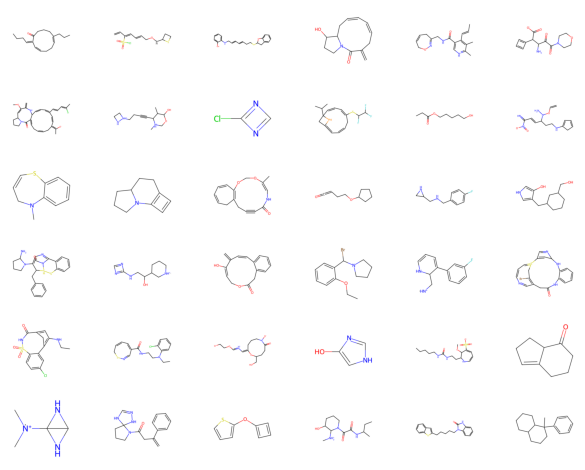

In [110]:
plot_smiles(valid_smiles, 6, 6, path=result_dir + 'smiles_transformer_generated_molecules.png')